<a href="https://colab.research.google.com/github/anwesha2004-bot/cuddly-fortnight/blob/main/Airplane_Passenger_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization,LSTM,Bidirectional,GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm

from tensorflow.keras.metrics import RootMeanSquaredError,MeanSquaredError
import sklearn.preprocessing

In [ ]:
df=pd.read_csv("/content/archive (16).zip")
month=df["Month"]

In [ ]:
#rename and set index like dates
df.rename(columns={'#Passengers': 'Passengers'}, inplace=True)
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')
df.set_index('Month', inplace=True)
df.tail(10)

,Passengers
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


In [ ]:
#another way  to turn 1 column to index
series = pd.read_csv("/content/archive (16).zip", header=0, index_col=0)
series

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121
...,...
1960-08,606
1960-09,508
1960-10,461


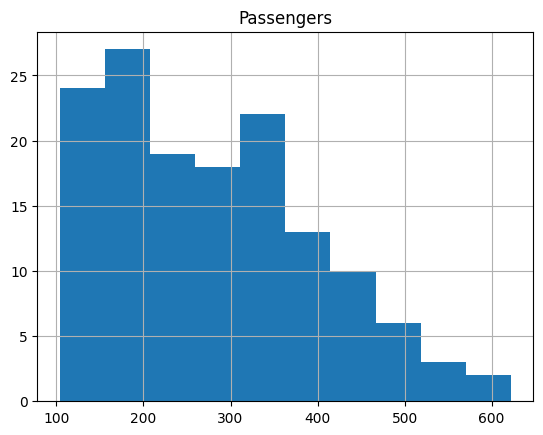

In [ ]:
# data has non - normal distribution, which means can use only MinMaxScaler

df.hist()

# Save the plot
plt.savefig('histogram.png')

# Show the plot (optional)
plt.show()

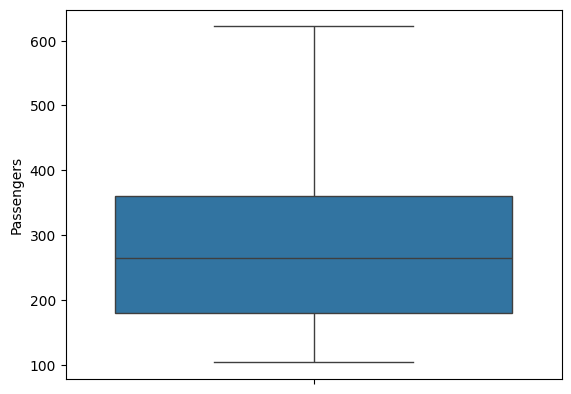

In [ ]:
#outliers check
#data has no outliers
sns.boxplot(df.Passengers)
plt.savefig('boxplot.png')
plt.show()

In [ ]:
#data has no missing values
print(df.describe())
print("NAN values:",df.isna().sum())

       Passengers
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000
NAN values: Passengers    0
dtype: int64


<function matplotlib.pyplot.show(close=None, block=None)>

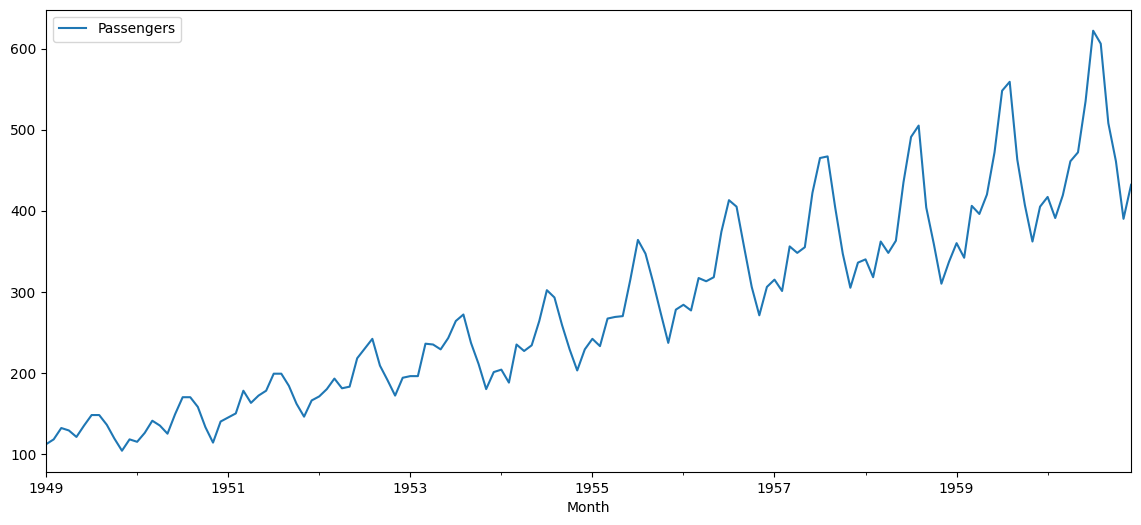

In [ ]:
df.plot(figsize=(14,6))
plt.savefig('Data.png')
plt.show

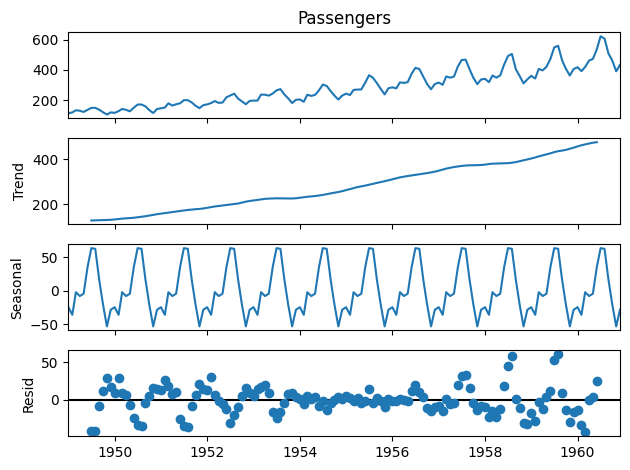

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposed = seasonal_decompose(df['Passengers'])

# Generate the plot
fig = decomposed.plot()

# Save the plot
fig.savefig('decomposed_plot.png')

# Show the plot (optional)
plt.show()

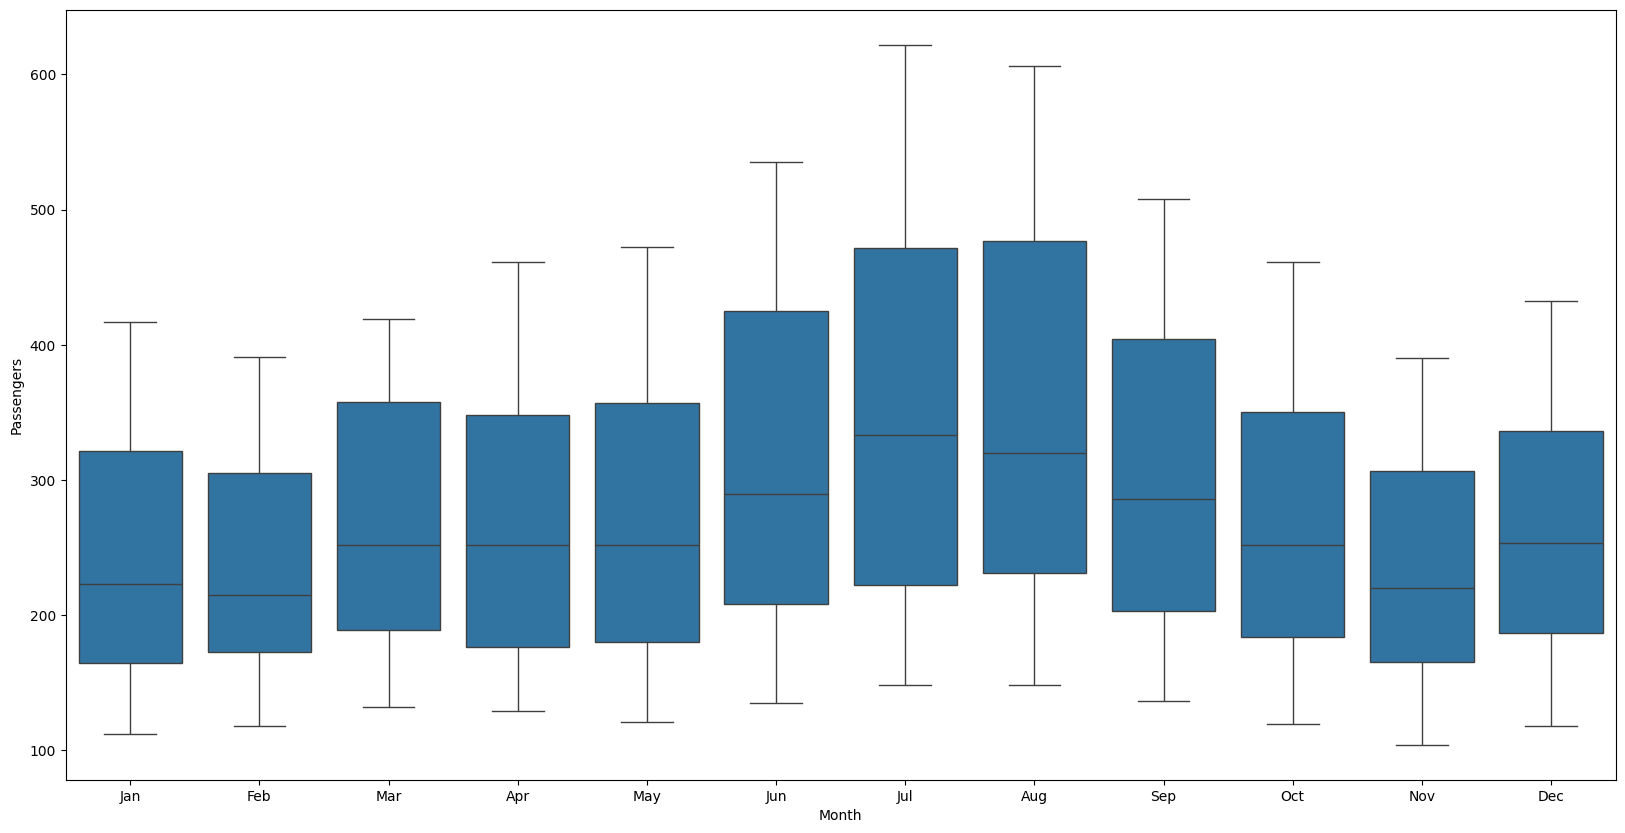

In [ ]:
df_month=df.copy()
df_month["Month"]=[d.strftime('%b') for d in df_month.index]

# Create the boxplot
plt.figure(figsize=(20,10))
sns.boxplot(x=df_month["Month"], y=df_month["Passengers"])

# Save the plot
plt.savefig('boxplot_monthly.png')

# Show the plot (optional)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(df):
    adf=adfuller(df)
    statistic= adf[0]
    p_value=adf[1]
    critical_values=adf[4]
    return p_value,statistic,critical_values
def stat_check(df,p_value_check=0.05):
    movingAverage = df.rolling(window=12).mean()
    movingSTD = df.rolling(window=12).std()
    orig = plt.plot(df, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    p_value,statistic,critical_values=adfuller_test(df)
    if (p_value<p_value_check):
        print('Time series is stationary, p value:{}'.format(p_value))
    else:
        print('Time series is NOT stationary, p value:{}'.format(p_value))
    print('Statistic:{}'.format(statistic))
    for key, value in critical_values.items():
        print('Critial Values:')
        print(f'   {key}, {value}')

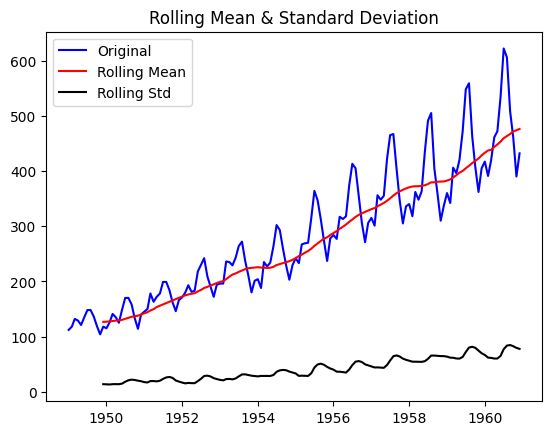

Time series is NOT stationary, p value:0.991880243437641
Statistic:0.8153688792060498
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 640x480 with 0 Axes>

In [ ]:
stat_check(df)
plt.savefig('meanandsd.png')
plt.show

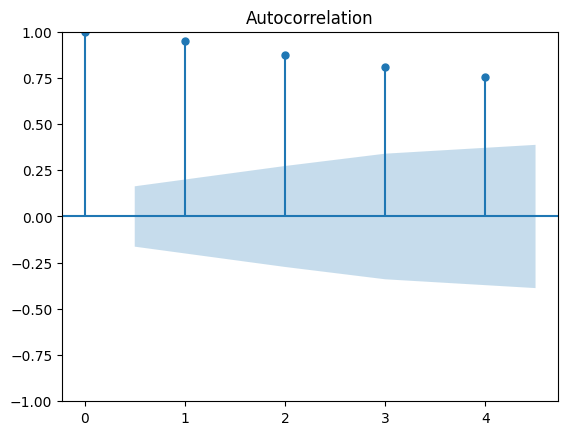

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df,lags=4)
plt.savefig('Autocorrelation.png')
plt.show()

In [ ]:
def calculate_mape(actual, predicted):

    if([isinstance(actual, np.ndarray) or isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),  np.array(predicted)
    else:
        actual, predicted = np.Int(actual),  np.Int(predicted)

    return round(np.mean(np.abs((
      actual - predicted) / actual)) * 100, 2)

In [ ]:
def arma_select_pq(df):
    arma_order = sm.tsa.arma_order_select_ic(df, ic=['aic', 'bic', 'hqic'], trend='c')
    p = arma_order.aic_min_order[0]
    q = arma_order.aic_min_order[1]
    return p,q

In [ ]:
naive=df.copy()
split_size=120
train_naive=naive[:split_size]
test=naive[split_size:]
y_naive=test.copy()
#take the last element (119) as future prediction
y_naive["naive forecasting"]= train_naive["Passengers"][split_size-1]

<ipython-input-17-3c1f01b14e74>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_naive["naive forecasting"]= train_naive["Passengers"][split_size-1]


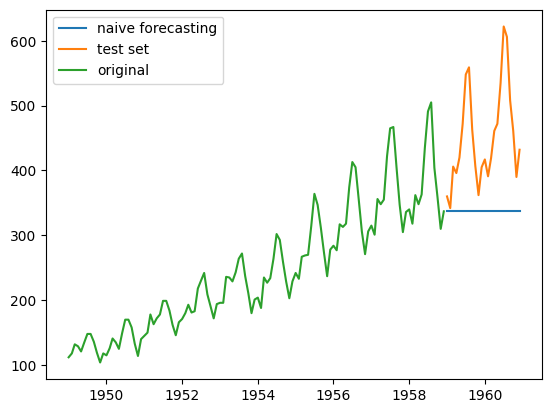

In [ ]:
plt.plot(y_naive["naive forecasting"])
plt.plot(y_naive["Passengers"])
plt.plot(train_naive["Passengers"])
plt.savefig('Naiveforec.png')
plt.legend(["naive forecasting","test set","original"])

In [ ]:
def deseasonality(df,seasonality):


    column_0=df.columns[0]
    diff = df[column_0].diff(periods=seasonality)
    diff=diff[seasonality:]
    return diff

In [ ]:
#Reverse to deasonality: add seasonality to TS
def add_seasonality(df,diff,seasonality):
    column_0=df.columns[0]
    summ=0
    if(type(diff) is pd.core.frame.DataFrame):
        summ = df[column_0].shift(seasonality) + diff[column_0]
        summ=summ[seasonality:]
    else:
        summ = df[column_0].shift(seasonality) + diff
        summ=summ[seasonality:]
    return summ

132


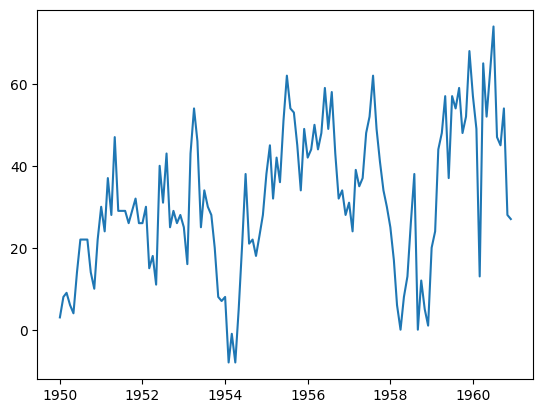

In [ ]:
deseasonality_df=deseasonality(df,12)
print(len(deseasonality_df))
plt.plot(deseasonality_df)
plt.show()

132


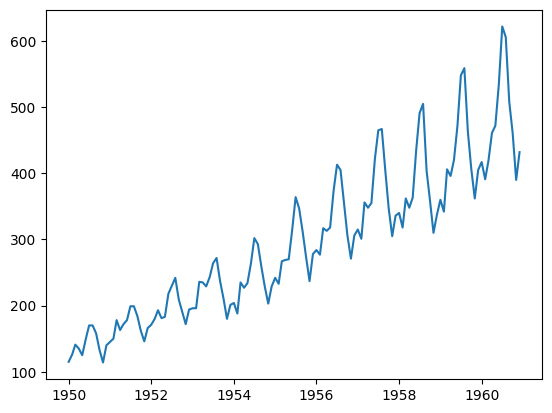

In [ ]:
#checking add_seasonality() and add removed seasonality back
de=add_seasonality(df,pd.DataFrame(deseasonality_df),12)
print(len(de))
plt.plot(de)
plt.show()

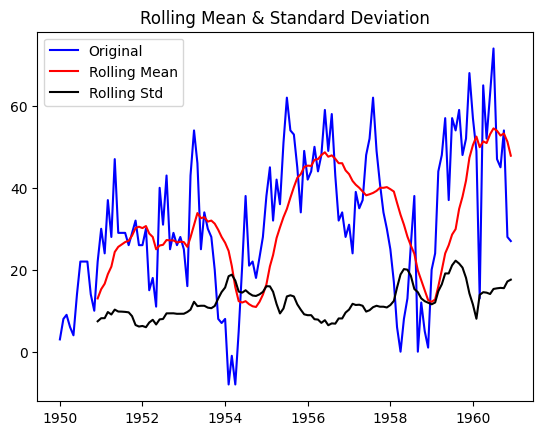

Time series is stationary, p value:0.011551493085514952
Statistic:-3.383020726492481
Critial Values:
   1%, -3.4816817173418295
Critial Values:
   5%, -2.8840418343195267
Critial Values:
   10%, -2.578770059171598


In [ ]:
deseasonality_df=pd.DataFrame(deseasonality_df)
stat_check(deseasonality_df)

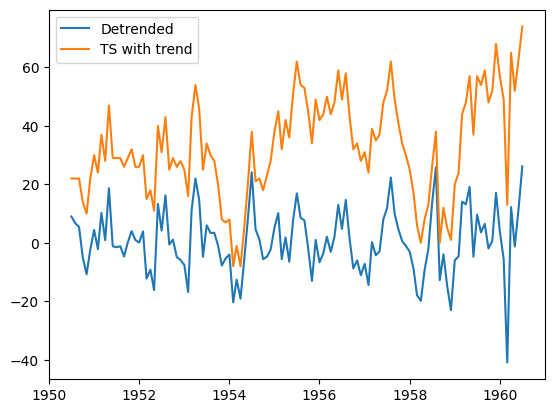

In [ ]:
rolling_mean = deseasonality_df.rolling(window=12, center=True).mean()
rolling_mean=rolling_mean.dropna()
detrended = deseasonality_df - rolling_mean
plt.plot(detrended)
detrended_w_trend=detrended+rolling_mean
plt.plot(detrended_w_trend)

plt.legend(["Detrended","TS with trend"])

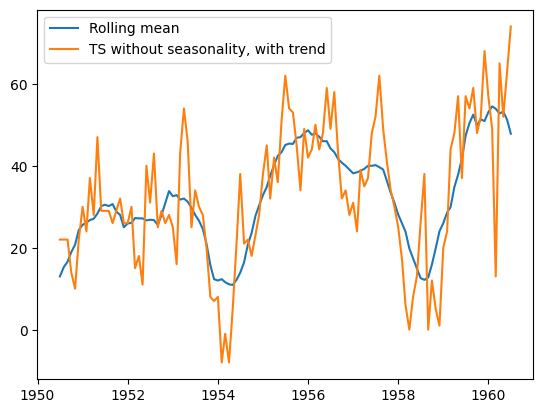

In [ ]:
plt.plot(rolling_mean)
detrended_w_trend=detrended+rolling_mean
plt.plot(detrended_w_trend)
plt.legend(["Rolling mean","TS without seasonality, with trend"])

In [ ]:
#save detrending and deseasonality ts to dataframe
df_detrended=pd.DataFrame(index=df[18:-5:].index)
df_detrended["Passengers"]=detrended
df_detrended.tail()

,Passengers
Month,
1960-03-01,-40.916667
1960-04-01,12.250000
1960-05-01,-1.250000
1960-06-01,11.750000
1960-07-01,26.166667


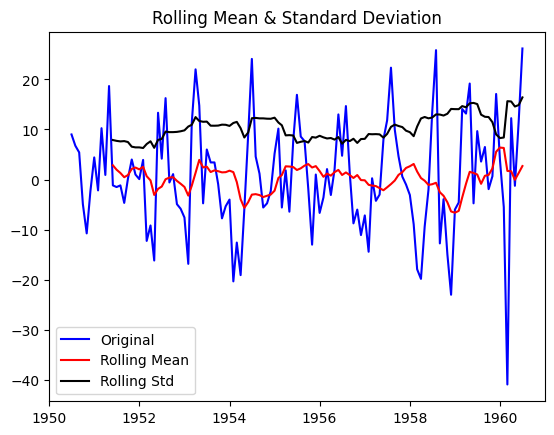

Time series is stationary, p value:1.2456645999354688e-09
Statistic:-6.906168409883201
Critial Values:
   1%, -3.487517288664615
Critial Values:
   5%, -2.8865777180380032
Critial Values:
   10%, -2.5801239192052012


In [ ]:
stat_check(df_detrended)

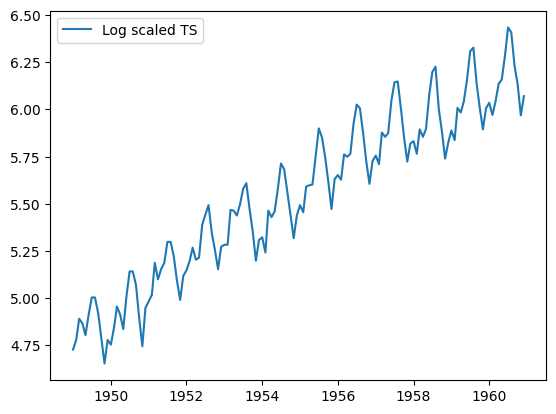

In [ ]:
#transform TS into log scale. Log scale TS still is NOT stationary
indexedDataset_logScale = np.log1p(df)
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
#substract mean from log scale TS to make it stationary
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
plt.plot(indexedDataset_logScale)
plt.legend(["Log scaled TS"])

,Passengers
Month,
1960-11-01,-0.182288
1960-12-01,-0.085623


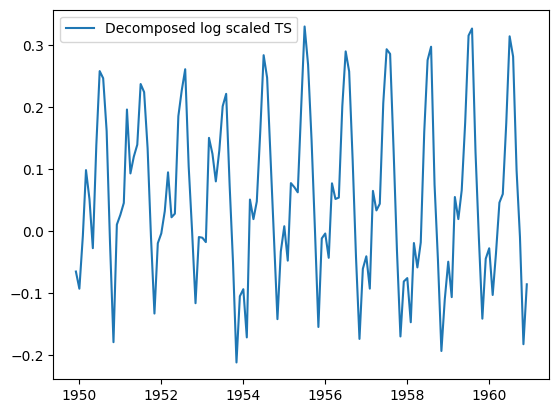

In [ ]:
plt.plot(datasetLogScaleMinusMovingAverage)
plt.legend(["Decomposed log scaled TS"])
datasetLogScaleMinusMovingAverage.tail(2)

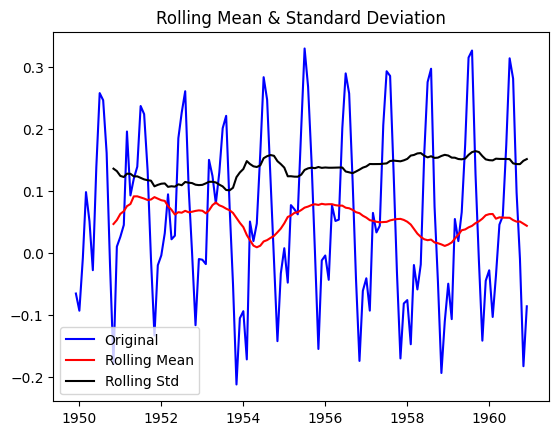

Time series is stationary, p value:0.021896955649249435
Statistic:-3.1682608249082014
Critial Values:
   1%, -3.4865346059036564
Critial Values:
   5%, -2.8861509858476264
Critial Values:
   10%, -2.579896092790057


In [ ]:
stat_check(datasetLogScaleMinusMovingAverage)

In [ ]:
p,q=arma_select_pq(datasetLogScaleMinusMovingAverage)
print("p:",p,"q:",q)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 3 q: 2


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
p,q=arma_select_pq(indexedDataset_logScale)
print("p:",p,"q:",q)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


p: 4 q: 2


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


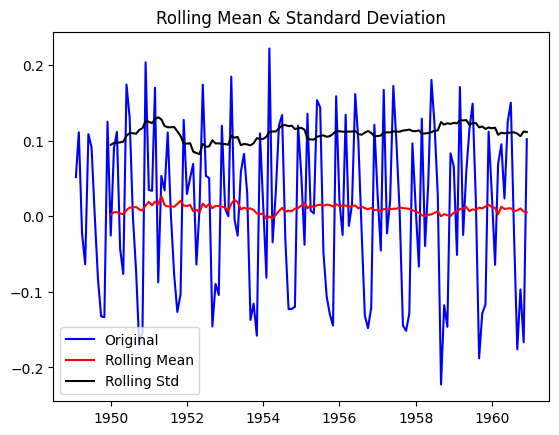

Time series is NOT stationary, p value:0.07031688936338104
Statistic:-2.7219468627063037
Critial Values:
   1%, -3.4825006939887997
Critial Values:
   5%, -2.884397984161377
Critial Values:
   10%, -2.578960197753906


In [ ]:
log_shifted=indexedDataset_logScale.shift()#shifting by 1 month
datasetLogDiffShifting = indexedDataset_logScale - log_shifted
datasetLogDiffShifting.dropna(inplace=True)
stat_check(datasetLogDiffShifting)

In [ ]:
#cloning to the working folder
!git clone https://github.com/aj-cloete/pssa
from pssa import mySSA

Cloning into 'pssa'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 110 (delta 6), reused 5 (delta 5), pack-reused 102 (from 1)
Receiving objects: 100% (110/110), 1.03 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
#check where mySSA.py file is
mySSA

<module 'pssa.mySSA' from '/content/pssa/mySSA.py'>

In [ ]:
<module 'pssa.mySSA' from '/content/pssa/mySSA.py'>

SyntaxError: invalid syntax (<ipython-input-49-b8bb28b369e6>, line 1)

In [ ]:
ts = pd.read_csv('/content/archive (16).zip', parse_dates=True, index_col='Month')
#create ssa object, first call file then function
ssa = mySSA.mySSA(ts)
ts.tail(10)

,#Passengers
Month,
1960-03-01,419
1960-04-01,461
1960-05-01,472
1960-06-01,535
1960-07-01,622
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390


In [ ]:
#method check
[x for x in dir(ssa) if '__' not in x and x[0]!='_']

['decompose',
 'diagonal_averaging',
 'embed',
 'forecast_recurrent',
 'freq',
 'get_contributions',
 'ts',
 'ts_N',
 'ts_name',
 'ts_v',
 'view_reconstruction',
 'view_s_contributions',
 'view_time_series']

In [ ]:
K = 40 #K = T − L + 1, where L<= L
suspected_seasonality = 12 #seasonality repeats every 12 month
#create trajectory matrix
ssa.embed(embedding_dimension=K, suspected_frequency=suspected_seasonality, verbose=True)

----------------------------------------
EMBEDDING SUMMARY:
Embedding dimension	:  36
Trajectory dimensions	: (36, 109)
Complete dimension	: (36, 109)
Missing dimension     	: (36, 0)


In [ ]:
ssa.decompose(verbose=True)
#Dimension of projection space is count of eigenvalues

----------------------------------------
DECOMPOSITION SUMMARY:
Rank of trajectory		: 36
Dimension of projection space	: 15
Characteristic of projection	: 0.9998


/content/pssa/mySSA.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


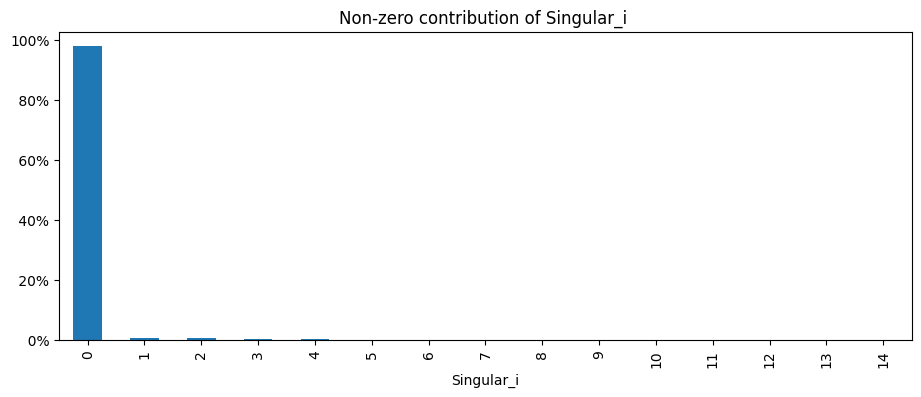

In [ ]:
#we can plot contribute of each signals (eaigenvalues)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 11, 4
ssa.view_s_contributions()

/content/pssa/mySSA.py:153: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])


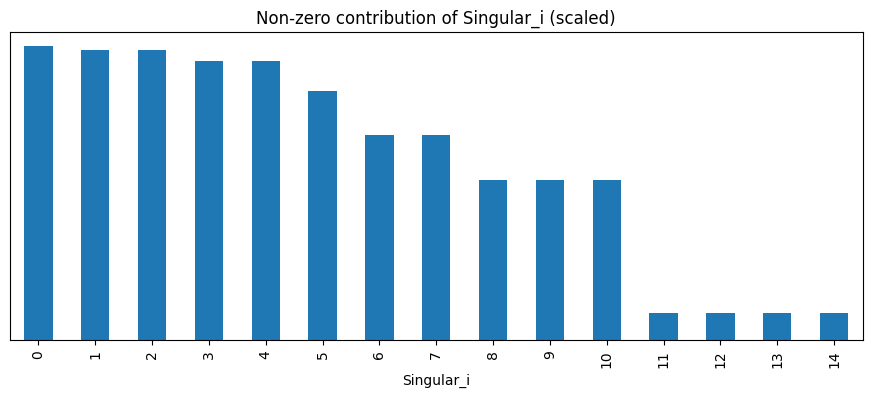

In [ ]:
#set adjust_scale for more information
ssa.view_s_contributions(adjust_scale=True)

/content/pssa/mySSA.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  velocity = hankel_full.abs().max()[0]
/content/pssa/mySSA.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  velocity = hankel_full.abs().max()[0]
/content/pssa/mySSA.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  velocity = hankel_full.abs().max()[0]
/content/pssa/mySSA.py:174: FutureWarning: Series.__getitem__ treating keys as positions is deprecat

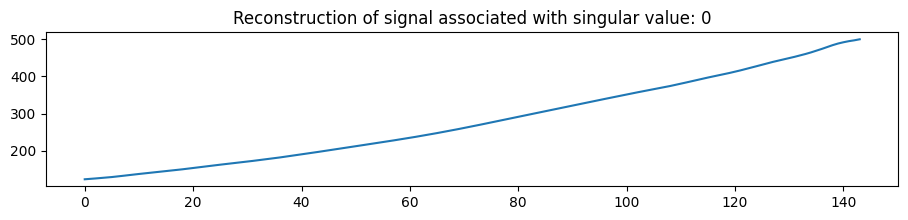

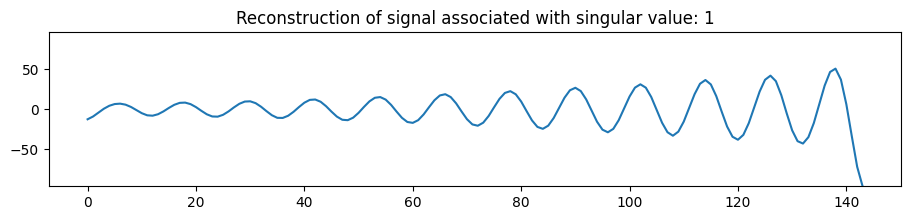

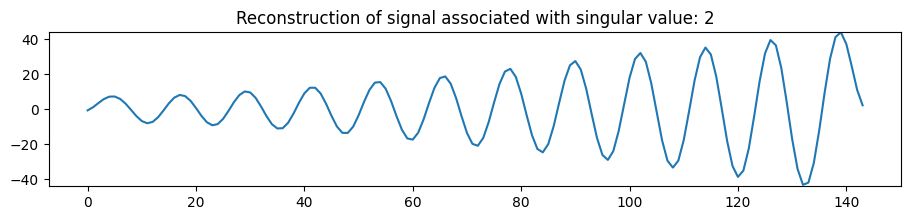

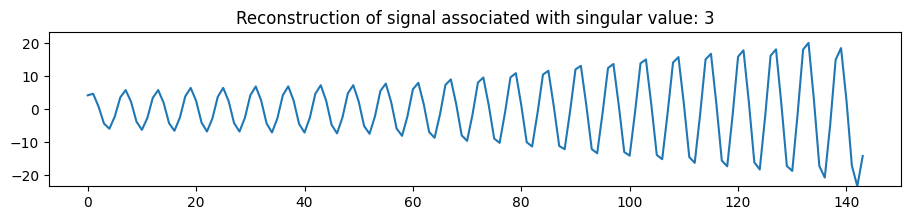

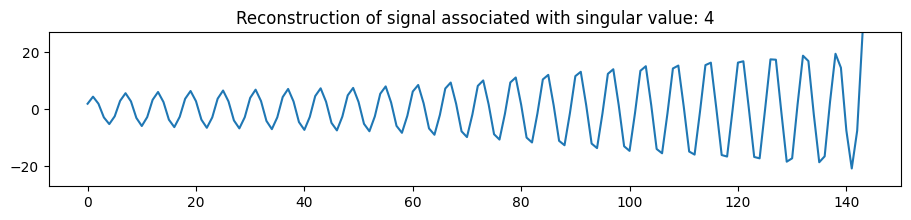

In [ ]:
#look at the first 5 signals
rcParams['figure.figsize'] = 11, 2
for i in range(5):
    ssa.view_reconstruction(ssa.Xs[i], names=i, symmetric_plots=i!=0)
rcParams['figure.figsize'] = 11, 4

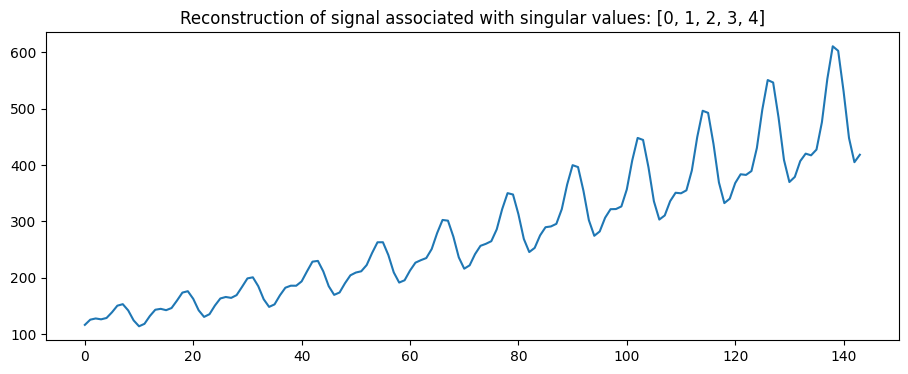

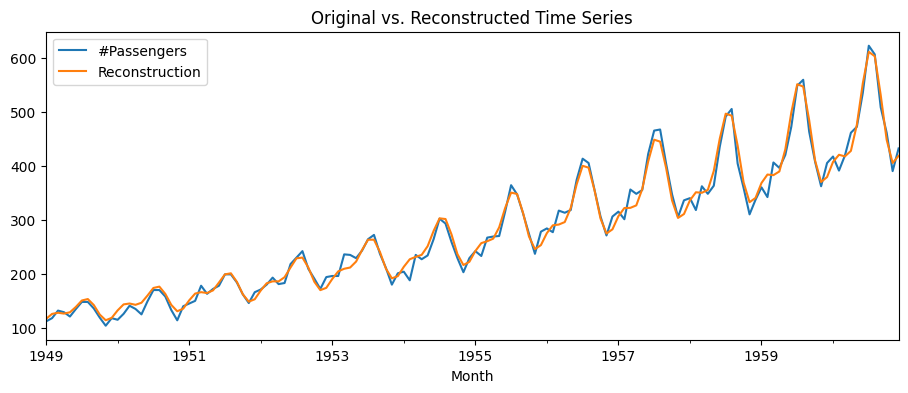

In [ ]:
#time series reconstruction with first 5 signals below
streams5 = [i for i in range(5)]
reconstructed5 = ssa.view_reconstruction(*[ssa.Xs[i] for i in streams5], names=streams5, return_df=True)
ts_copy5 = ssa.ts.copy()
ts_copy5['Reconstruction'] = reconstructed5.Reconstruction.values
ts_copy5.plot(title='Original vs. Reconstructed Time Series');

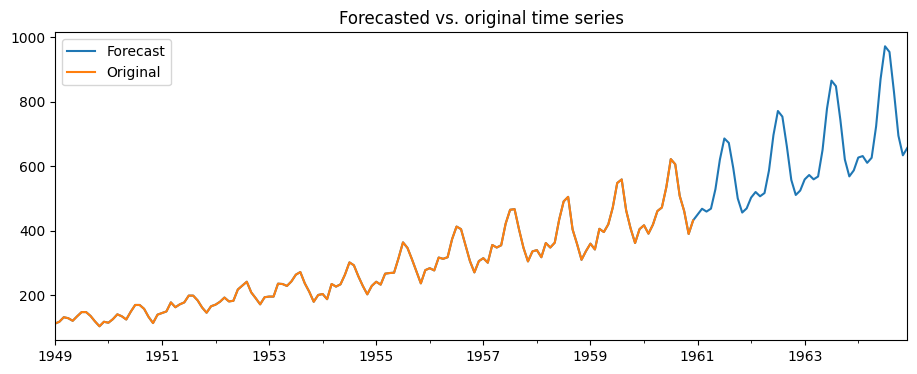

In [ ]:
ssa_forecast_5=ssa.forecast_recurrent(steps_ahead=48, singular_values=streams5, plot=True,return_df=True)
plt.savefig('SSA_forecast.png')
plt.show()

In [ ]:
#round values
ssa_forecast_5["Forecast"]=[round(value) for value in ssa_forecast_5["Forecast"]]

In [ ]:
ssa_forecast_5

,Forecast,Original
1949-01-01,112,112.0
1949-02-01,118,118.0
1949-03-01,132,132.0
1949-04-01,129,129.0
1949-05-01,121,121.0
...,...,...
1964-08-01,954,NaN
1964-09-01,830,NaN
1964-10-01,695,NaN
1964-11-01,634,NaN


In [ ]:
print("MSE:", float(tf.keras.metrics.MeanSquaredError()(ssa_forecast_5["Original"][:144], ssa_forecast_5["Forecast"][:144]).numpy()))
print("MAE:", float(tf.keras.metrics.MeanAbsoluteError()(ssa_forecast_5["Original"][:144], ssa_forecast_5["Forecast"][:144]).numpy()))
print("MAPE (Accuracy):", float(100 - calculate_mape(ssa_forecast_5["Original"][:144], ssa_forecast_5["Forecast"][:144])))
ssa5_mape = calculate_mape(ssa_forecast_5["Original"][:144], ssa_forecast_5["Forecast"][:144])

MSE: 0.0
MAE: 0.0
MAPE (Accuracy): 100.0
